# Combined Extraction of Location and Geocoding Pipeline

The notebook automates the Extraction, Cleaning, Geocoding, and Mapping of location data from academic theses.

It first filters out non-content sections like cover pages and references before converting the main body of each PDF into text with preserved page mapping.

Locations are then identified using three extractors—spaCy for named entities, GeoText for cities and countries, and regex for GPS-style coordinates—and cleaned to remove generic terms and author names.

Paragraphs are passed through a few-shot LLM to refine results, after which only LLM and LLM-plus-rules outputs are kept for geocoding.

The final geocoding stage combines GeoPy with custom coordinate parsers that handle decimal, DMS, and UTM formats, adding latitude, longitude, and geocode type to each record while marking unmatched items as “no-geocode-result.”

Duplicate localities are merged to retain all mentions and pages, and an interactive Folium map visualizes the results with popups showing each location’s context, providing an efficient pipeline for transforming unstructured text into verifiable geospatial data.

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.5 MB/s eta 0:00:00


In [3]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.8/999.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.109.1
    Uninstalling openai-1.109.1:
      Successfully uninstalled openai-1.109.1


In [4]:
!pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.6 MB/s eta 0:00:00


In [5]:
!pip install geotext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.5 MB/s eta 0:00:00


In [6]:
#Imports
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer
import pandas as pd
import json
import re
import os
import openai
from openai import OpenAI
import time
import ast
import io
import csv
from typing import List, Tuple
from collections import defaultdict
import spacy
from geotext import GeoText
import unidecode
from io import StringIO
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
import itertools
from pathlib import Path
import os, re
import pandas as pd
import numpy as np
from pyproj import Transformer
from matplotlib_venn import venn2
import matplotlib.pyplot as plt


## Extract Data from PDF

This section handles PDF text extraction and preprocessing. It filters out non-relevant sections such as cover pages, acknowledgements, references, and converts the main body into text with page mapping for later location lookup.

In [7]:
def extract_pages_text(pdf_path):
    """ Input: PDF files
        Output: list of pages as text(strings)
    """
    pages = []
    for page_layout in extract_pages(pdf_path):
        lines = []
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                lines.append(element.get_text())
        page_text = '\n'.join(lines)
        pages.append(page_text)
    return pages

In [8]:
def is_toc_page(text):
    if "table of contents" in text or "contents" in text:
        return True
    if re.search(r'\.{5,}', text) and re.search(r'\d{1,3}\s*$', text, re.MULTILINE):
        return True
    if sum(1 for l in text.split('\n') if re.match(r'.*\d{1,3}\s*$', l)) > 5:
        return True
    return False

def is_ack_page(text):
    return "acknowledgement" in text or "acknowledgments" in text

def is_declaration_page(text):
    return "declaration" in text

def is_main_section_start(text):
    return bool(re.search(
        r'\b(?:1\.|chapter\s*1)[:\s-]*introduction\b|\bintroduction\b',
        text, re.IGNORECASE
    ))

def remove_empty_lines(text):
    return "\n".join(line for line in text.splitlines() if line.strip())

In [9]:
def remove_references_sections(page_texts):
    """
    Removes 'References' sections from each page and drops any blank pages.
    Input: list of page_texts (strings)
    Output: list of cleaned page_texts (strings)
    """
    cleaned_pages = []
    skip_mode = False
    for page in page_texts:
        lines = page.splitlines()
        cleaned_lines = []
        for line in lines:
            # Detect references header
            if not skip_mode and re.match(r'^\s*(\d+\.?)?\s*references\b', line, re.I):
                skip_mode = True
                continue
            # Exit skip mode if a new section/chapter starts
            if skip_mode and (
                re.match(r'^\s*(chapter|paper|section|abstract|introduction)\b', line, re.I) or
                re.match(r'^\s*(\d+\.?)?\s*(abstract|introduction|chapter|paper|section)\b', line, re.I)
            ):
                skip_mode = False
            if not skip_mode:
                cleaned_lines.append(line)
        # Remove empty lines
        non_empty = [l for l in cleaned_lines if l.strip()]
        # If after cleaning, page is not blank, keep it
        if non_empty:
            cleaned_pages.append('\n'.join(non_empty))
    return cleaned_pages

In [10]:
def pdf_to_text_with_page_mapping(pdf_path):
    pages = extract_pages_text(pdf_path)
    body_pages = pages[1:]  # Removes cover page
    filtered_pages = []
    kept_pages = []
    skip_mode = None
    original_page_numbers = list(range(2, len(pages)+1))

    for idx, pg in enumerate(body_pages):
        pg_lower = pg.lower()
        if skip_mode == 'toc':
            if is_main_section_start(pg_lower):
                skip_mode = None
            elif is_toc_page(pg_lower):
                continue
            else:
                skip_mode = None
        elif skip_mode == 'ack':
            if is_main_section_start(pg_lower):
                skip_mode = None
            elif is_ack_page(pg_lower):
                continue
            else:
                skip_mode = None
        elif skip_mode == 'dec':
            if is_main_section_start(pg_lower):
                skip_mode = None
            elif is_declaration_page(pg_lower):
                continue
            else:
                skip_mode = None
        if skip_mode is None:
            if is_toc_page(pg_lower):
                skip_mode = 'toc'
                continue
            elif is_ack_page(pg_lower):
                skip_mode = 'ack'
                continue
            elif is_declaration_page(pg_lower):
                skip_mode = 'dec'
                continue
        filtered_pages.append(pg)
        kept_pages.append(original_page_numbers[idx])

    main_body_text = "\n\n".join(remove_empty_lines(pg) for pg in filtered_pages)

    return main_body_text, kept_pages, filtered_pages

In [11]:
def process_pdf_folder(folder_path, output_txt_folder=None, csv_report_path=None):
    """
    Processes all PDFs in the given folder:
    - Extracts text (and keeps track of page numbers).
    - Removes all content from the References section onwards.
    - Writes cleaned text to .txt files (with page markers).
    - Prints and optionally saves a count per file as CSV.
    """
    if output_txt_folder:
        os.makedirs(output_txt_folder, exist_ok=True)
    report = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.pdf'):
            pdf_path = os.path.join(folder_path, filename)
            print(f"Processing: {filename}")
            try:
                main_text, kept_page_nums, kept_page_texts = pdf_to_text_with_page_mapping(pdf_path)
                kept_page_texts_norefs = remove_references_sections(kept_page_texts)
                kept_page_nums_norefs = kept_page_nums[:len(kept_page_texts_norefs)]

                if output_txt_folder:
                    txt_filename = os.path.splitext(filename)[0] + ".txt"
                    txt_path = os.path.join(output_txt_folder, txt_filename)
                    with open(txt_path, "w", encoding="utf-8") as f:
                        for page_num, page_text in zip(kept_page_nums_norefs, kept_page_texts_norefs):
                            f.write(f"\n--- Page {page_num} ---\n")
                            f.write(remove_empty_lines(page_text).strip() + "\n")
                report.append({"filename": filename, "kept_pages": len(kept_page_nums_norefs)})
            except Exception as e:
                print(f"Failed to process {filename}: {e}")
    print("\n=== Page Count Report ===")
    for row in report:
        print(f"{row['filename']}: {row['kept_pages']} pages kept")
    if csv_report_path:
        pd.DataFrame(report).to_csv(csv_report_path, index=False)
    return report

In [12]:
if __name__ == "__main__":
    folder = "/content/drive/MyDrive/data_pdf"
    out_folder = "/content/drive/MyDrive/Data_txt"
    report_csv = "/content/drive/MyDrive/pdf_page_report.csv"
    process_pdf_folder(folder, out_folder, report_csv)

Processing: 2013_Peters.pdf
Processing: 2015_Masurel_phd.pdf
Processing: 2013_FUNYUFUNYU.pdf
Processing: 2014_MSc_YOSSI.pdf
Processing: 2015_LeBrun_Siguiri.pdf
Processing: 2008_MATABANE_FE3.pdf
Processing: 2011_Peters_East Markoye_2011.pdf
Processing: 2010_Matsheka_Irvin Final Thesis.pdf
Processing: 2013_Ramabulana_Sadiola Hill petrology.pdf
Processing: 2007_Tshibubudze_THE MARKOYE FAULT_2007.pdf
Processing: 2009_Bontle Nkuna_0605886P_Honours Report.pdf
Processing: 2010_Mohale_GIS interpretation of NE Burkina Faso.pdf
Processing: 2011_Woolfe_The stratigraphy and metamorphic facies of the KEMB.pdf
Processing: 2012_Simoko_Petrology, geochemistry and structure of the Pissila batholith and the Saaba Zone gneiss.pdf

=== Page Count Report ===
2013_Peters.pdf: 77 pages kept
2015_Masurel_phd.pdf: 227 pages kept
2013_FUNYUFUNYU.pdf: 71 pages kept
2014_MSc_YOSSI.pdf: 38 pages kept
2015_LeBrun_Siguiri.pdf: 191 pages kept
2008_MATABANE_FE3.pdf: 39 pages kept
2011_Peters_East Markoye_2011.pdf: 50 

In [13]:
def text_to_sentence_paragraphs(text, sentences_per_paragraph=6):
    # Basic sentence splitter
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    paragraphs = []
    for i in range(0, len(sentences), sentences_per_paragraph):
        para = " ".join(sentences[i:i+sentences_per_paragraph])
        paragraphs.append(para)
    return paragraphs

def txt_file_to_page_paragraphs(txt_path, sentences_per_paragraph=6):
    """
    Reads a .txt file with "--- Page N ---" markers,
    returns a list of dicts: {"filename", "page", "paragraph"}
    """
    filename = os.path.basename(txt_path)
    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Split by page marker
    page_blocks = re.split(r'\n?--- Page (\d+) ---\n', text)
    out = []
    # page_blocks[0] is any text before the first page (often empty)
    for i in range(1, len(page_blocks), 2):
        page_num = int(page_blocks[i])
        page_text = page_blocks[i+1]
        paragraphs = text_to_sentence_paragraphs(page_text, sentences_per_paragraph)
        for para in paragraphs:
            if para.strip():
                out.append({
                    "filename": filename,
                    "page": page_num,
                    "paragraph": para.strip()
                })
    return out

def folder_txts_to_page_paragraphs(folder_path, sentences_per_paragraph=6):
    """
    For all .txt files in folder, returns a list of dicts:
    filename, page, paragraph
    """
    all_paragraphs = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".txt"):
            file_path = os.path.join(folder_path, fname)
            out = txt_file_to_page_paragraphs(file_path, sentences_per_paragraph)
            all_paragraphs.extend(out)
    return all_paragraphs

## Rules

This section applies rule-based extraction methods including spaCy, GeoText, and regex patterns. It identifies cities, countries, coordinates, and region names from text, then cleans, deduplicates, and normalizes the results for merging.

In [14]:
COMPASS = {"N","S","E","W","NE","NW","SE","SW"}
DENY_SINGLE = {
    "al.", "et", "al", "date", "university", "université", "ministere", "orpailleur", "brgm",
    "thièblemont", "yacouba"
}
DENY_TITLES = {"university", "declaration", "preamble", "chapter", "figure", "table"}
DENY_PHRASE_PREFIXES = (
    "geologists at", "in this region", "various geological features",
    "between the towns", "the region", "the desert", "the capital city"
)

def looks_like_location_token(t: str) -> bool:
    s = t.strip()
    if not s: return False
    if len(s) <= 2: return False
    if s.upper() in COMPASS: return False
    if s.lower() in DENY_SINGLE: return False
    if s.endswith("."): return False
    if re.fullmatch(r"[^\w]+", s): return False
    return True

def looks_like_location_phrase(t: str) -> bool:
    s = re.sub(r"\s+", " ", t.strip())
    if not looks_like_location_token(s):
        return False
    low = s.lower()
    if low in DENY_TITLES: return False
    if any(low.startswith(pref) for pref in DENY_PHRASE_PREFIXES): return False
    if s.isupper() and " " not in s and not re.search(r"[-’']", s):
        return False
    words = s.split()
    if len(words) >= 2:
        titleish = sum(w[:1].isupper() for w in words) >= 1
        if not titleish: return False
    return True

In [15]:
def spacy_extract_locations(paragraphs):
    nlp = spacy.load("en_core_web_sm")
    out = []
    for item in paragraphs:
        filename = item['filename']
        page = item['page']
        para = item['paragraph']
        doc = nlp(para)
        for ent in doc.ents:
            if ent.label_ in {"GPE", "LOC", "FAC"}:
                loc_text = ent.text.strip()
                if looks_like_location_token(loc_text):
                    out.append({
                        "filename": filename,
                        "page": page,
                        "mention": para,
                        "location": loc_text,
                        "label": ent.label_,
                        "source": "spacy"
                    })
    return out

In [16]:
def geotext_extract_locations(paragraphs):
    """
    For each paragraph dict (filename, page, paragraph),
    extract city/country mentions using GeoText.
    Output: list of dicts with filename, page, mention (the paragraph), location, and label ("GEO").
    """
    out = []
    for item in paragraphs:
        filename = item['filename']
        page = item['page']
        para = item['paragraph']
        places = GeoText(para)
        # Combine all found locations
        locs = set(list(places.cities) + list(places.countries))
        for loc in locs:
            if looks_like_location_token(loc):
                out.append({
                    "filename": filename,
                    "page": page,
                    "mention": para,
                    "location": loc,
                    "label": "GEO",
                    "source": "geotext"
                })
    return out

In [17]:
def regex_geo_spans(text: str) -> List[Tuple[int, int, str, str, str]]:
    """
    Find geographic phrases using regex patterns.

    Matches three main cases:
      1. Proper name(s) followed by a geo suffix (e.g. "Ashanti Belt", "West African Craton")
      2. Directional phrase + proper name (e.g. "West Africa", "Eastern Highlands")
      3. Proper name(s) + geo unit (e.g. "Essakane Mine", "Tarkwa Basin", "Pilbara Region")

    Returns a list of spans: (start_index, end_index, source, label, text)
    """

    # case-insensitive suffixes that define a geo phrase
    geo_suffixes = (
        r"(?i:"  # (?i:) = case-insensitive group
        r"Belt|Greenstone Belt|Craton|Basin|Shear Zone|Fault|Goldfield|Range|Desert|River|"
        r"Lake|Sea|Ocean|Gulf|Province|State|Region|Valley|Plateau|Peninsula|Archipelago|"
        r"Canyon|Strait|Channel|Highlands|Lowlands|Orogeny|Greenstone"
        r")"
    )

    # pattern 1: ProperName (+ ProperName …) + geo suffix
    pattern_suffix = re.compile(
        rf"""\b(?:[A-Z][\w’'-]*(?:\s+[A-Z][\w’'-]*){{0,5}})\s+{geo_suffixes}\b"""
    )

    # pattern 2: Direction word + ProperName (e.g. "West Africa")
    pattern_direction = re.compile(
        r"""\b(?:North|South|East|West|Northern|Southern|Eastern|Western)\s+"""
        r"""[A-Z][\w’'-]+(?:\s+[A-Z][\w’'-]+){0,3}\b"""
    )

    # pattern 3: ProperName + geo unit like Mine/Region/City
    pattern_unit = re.compile(
        r"""\b(?:[A-Z][\w’'-]+(?:\s+[A-Z][\w’'-]+){0,4})\s+"""
        r"""(?i:Mine|Mines|Goldmine|Goldfield|District|Province|Region|County|City|Town|Village)s?\b"""
    )

    # quick quality check: phrase must look like a proper title
    def looks_titlecase(phrase: str) -> bool:
        phrase = re.sub(r"\s+", " ", phrase.strip())
        tokens = phrase.split()
        if not tokens:
            return False
        # single token: must start uppercase
        if len(tokens) == 1:
            return tokens[0][0].isupper()
        # multiword: at least half tokens start uppercase
        uppercase_count = sum(tok[0].isupper() for tok in tokens)
        return uppercase_count >= max(2, len(tokens) // 2)

    spans = []
    for pattern in (pattern_suffix, pattern_direction, pattern_unit):
        for match in pattern.finditer(text):
            candidate = text[match.start():match.end()]
            if looks_titlecase(candidate) and looks_like_location_phrase(candidate):
                spans.append((match.start(), match.end(), "regex", "GEO", candidate))

    return spans

In [18]:
def regex_geo_extract_paragraphs(paragraphs):
    """
    For each paragraph dict (filename, page, paragraph),
    extract regex-matched locations.
    Output: list of dicts: filename, page, mention, location, label ("regex-GEO")
    """
    results = []
    for item in paragraphs:
        filename = item['filename']
        page = item['page']
        para = item['paragraph']
        spans = regex_geo_spans(para)
        for start, end, src, label, loc in spans:
            results.append({
                "filename": filename,
                "page": page,
                "mention": para,
                "location": loc,
                "label": "regex-GEO",
                "source": "regex"
            })
    return results

In [19]:
LEADING_DROP = (
    r"the\b", r"preamble\b", r"conclusion\b", r"at\b"
)

# Compass modifiers like “NE-trending”, “NW-striking”, etc. to strip (case-insensitive)
LEADING_COMPASS = r"(?:\b[NS][EW]?\s*-(?:trending|striking)\b\s*)+"

# If any of these substrings appear, reject the candidate (case-insensitive)
REJECT_SUBSTRINGS = (
    "declaration", "journal", "research ", "figure", "table",
    "universite", "university", "ministere", "ministry",
    "geologists at", "capital city", "between the towns",
    "various geological features", "in this region"
)

# Single-word denials (exact, case-insensitive)
REJECT_SINGLE = {"harmattan", "north-east", "earth", "subcrop"}

# If present as a standalone token (case-sensitive), reject (common surnames/initials)
REJECT_TOKENS = {"Rogers", "Davis", "K.A.A"}

# Geo suffixes we consider meaningful for regex candidates
GEO_SUFFIX_WORDS = {
    "Belt","Greenstone Belt","Craton","Basin","Shear Zone","Fault","Goldfield",
    "Range","Desert","River","Lake","Sea","Ocean","Gulf","Province","State",
    "Region","Valley","Plateau","Peninsula","Archipelago","Canyon","Strait",
    "Channel","Highlands","Lowlands","Orogeny","Greenstone","Mine","Mines",
    "Goldmine","District","County","City","Town","Village"
}

def _titlecase_if_allcaps(s: str) -> str:
    # Keep acronyms with digits/short bits as-is; otherwise Title Case ALL-CAPS for display
    if s.isupper() and len(s) > 3 and not re.search(r"\d", s):
        return " ".join(w.capitalize() if len(w) > 1 else w for w in s.split())
    return s

def _strip_leading_noise(s: str) -> str:
    t = s.strip()
    # remove compass “NE-trending …” style sequences first
    t = re.sub(rf"^{LEADING_COMPASS}", "", t, flags=re.IGNORECASE)
    # strip determiners/section words like The/Preamble/Conclusion/At (possibly repeated)
    changed = True
    while changed:
        changed = False
        for key in LEADING_DROP:
            new_t = re.sub(rf"^{key}\s+", "", t, flags=re.IGNORECASE)
            if new_t != t:
                t = new_t
                changed = True
    return t.strip()

def _has_geo_suffix(s: str) -> bool:
    # true if ends with one of our geo suffix tokens (case-insensitive)
    for suf in GEO_SUFFIX_WORDS:
        if re.search(rf"\b{re.escape(suf)}\b$", s, flags=re.IGNORECASE):
            return True
    return False

def _looks_like_geo(s: str, source: str, label: str) -> bool:
    low = s.lower()
    if any(sub in low for sub in REJECT_SUBSTRINGS):
        return False
    toks = s.split()
    if len(toks) == 1 and low in REJECT_SINGLE:
        return False
    if any(tok in REJECT_TOKENS for tok in toks):
        return False
    # For regex candidates, strongly prefer a geo suffix (“… Fault”, “… Basin”, “… Region”, …)
    if source == "regex":
        return _has_geo_suffix(s)
    # For spaCy/GeoText, allow country/city/GPE tokens even without suffix
    # but require Title-ish casing (not all-lowercase).
    if s[0].islower():
        return False
    return True

def _norm_for_dedup_paragraph(loc: str) -> str:
    s = re.sub(r"\s+", " ", loc.strip())
    s = _strip_leading_noise(s)
    return s.lower()

def _clean_location_display_paragraph(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip())
    s = _strip_leading_noise(s)
    s = _titlecase_if_allcaps(s)
    return s

In [20]:
def dedup_paragraph_location_results_from_lists(*results_lists):
    """
    Accepts any number of result lists (e.g. spacy, geotext, regex), flattens, dedups, and returns
    list of dicts: filename, page, mention, location, label, source.
    """
    # Flatten all results into one list
    all_results = []
    for lst in results_lists:
        all_results.extend(lst)

    seen = set()
    rows = []
    for d in all_results:
        fname = d['filename']
        page = d['page']
        para = d['mention']
        loc = d['location']
        label = d['label']
        source = d.get('source', 'unknown')
        loc_disp = _clean_location_display_paragraph(loc)
        if not _looks_like_geo(loc_disp, source, label):
            continue
        key = (fname, _norm_for_dedup_paragraph(loc_disp))
        if key in seen:
            continue
        seen.add(key)
        rows.append({
            "filename": fname,
            "page": page,
            "mention": para,
            "location": loc_disp,
            "label": label,
            "source": source
        })
    return rows

In [29]:
def process_txt_folder_to_csvs(folder_path, out_csv_folder, sentences_per_paragraph=6, summary_csv=None):
    import pandas as pd
    from collections import defaultdict
    import os

    os.makedirs(out_csv_folder, exist_ok=True)
    all_paragraphs = folder_txts_to_page_paragraphs(folder_path, sentences_per_paragraph)
    file_to_paragraphs = defaultdict(list)
    for p in all_paragraphs:
        file_to_paragraphs[p["filename"]].append(p)

    summary = []

    for fname, paragraphs in file_to_paragraphs.items():
        print(f"Processing {fname}...")
        spacy_results = spacy_extract_locations(paragraphs)
        geotext_results = geotext_extract_locations(paragraphs)
        regex_results = regex_geo_extract_paragraphs(paragraphs)

        n_spacy = len({d['location'] for d in spacy_results if d.get('location')})
        n_geotext = len({d['location'] for d in geotext_results if d.get('location')})
        n_regex = len({d['location'] for d in regex_results if d.get('location')})

        deduped = dedup_paragraph_location_results_from_lists(
            spacy_results, geotext_results, regex_results
        )

        n_total = len({d['location'] for d in deduped if d.get('location')})

        out_csv = os.path.join(out_csv_folder, fname.replace(".txt", "_locations.csv"))
        pd.DataFrame(deduped).to_csv(out_csv, index=False)
        print(f"Saved to {out_csv}, {n_total} unique locations.")


        summary.append({
            "filename": fname,
            "spacy_locations": n_spacy,
            "geotext_locations": n_geotext,
            "regex_locations": n_regex,
            "total_deduped": n_total
        })

    # Summary of rules count
    if summary_csv is None:
        summary_csv = os.path.join(out_csv_folder, "rules_extraction_summary.csv")
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(summary_csv, index=False)
    print(f"Saved summary to {summary_csv}")

    return summary_df


In [30]:
process_txt_folder_to_csvs("/content/drive/MyDrive/Data_txt", "/content/drive/MyDrive/Rules_Locations")

Processing 2013_Peters.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2013_Peters_locations.csv, 125 unique locations.
Processing 2015_Masurel_phd.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2015_Masurel_phd_locations.csv, 319 unique locations.
Processing 2013_FUNYUFUNYU.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2013_FUNYUFUNYU_locations.csv, 200 unique locations.
Processing 2014_MSc_YOSSI.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2014_MSc_YOSSI_locations.csv, 109 unique locations.
Processing 2015_LeBrun_Siguiri.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2015_LeBrun_Siguiri_locations.csv, 255 unique locations.
Processing 2008_MATABANE_FE3.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2008_MATABANE_FE3_locations.csv, 62 unique locations.
Processing 2011_Peters_East Markoye_2011.txt...
Saved to /content/drive/MyDrive/Rules_Locations/2011_Peters_East Markoye_2011_locations.csv, 98 unique locations.
Processing 2010_Matsheka_

,filename,spacy_locations,geotext_locations,regex_locations,total_deduped
0,2013_Peters.txt,87,47,25,125
1,2015_Masurel_phd.txt,263,82,90,319
2,2013_FUNYUFUNYU.txt,165,71,37,200
3,2014_MSc_YOSSI.txt,83,29,62,109
4,2015_LeBrun_Siguiri.txt,187,69,110,255
5,2008_MATABANE_FE3.txt,51,24,22,62
6,2011_Peters_East Markoye_2011.txt,83,29,35,98
7,2010_Matsheka_Irvin Final Thesis.txt,23,18,17,41
8,2013_Ramabulana_Sadiola Hill petrology.txt,36,13,13,46
9,2007_Tshibubudze_THE MARKOYE FAULT_2007.txt,31,15,24,42


from matplotlib import pyplot as plt
_df_0['spacy_locations'].plot(kind='hist', bins=20, title='spacy_locations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['geotext_locations'].plot(kind='hist', bins=20, title='geotext_locations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['regex_locations'].plot(kind='hist', bins=20, title='regex_locations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['total_deduped'].plot(kind='hist', bins=20, title='total_deduped')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='spacy_locations', y='geotext_locations', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='geotext_locations', y='regex_locations', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='regex_locations', y='total_deduped', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['spacy_locations'].plot(kind='line', figsize=(8, 4), title='spacy_locations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['geotext_locations'].plot(kind='line', figsize=(8, 4), title='geotext_locations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['regex_locations'].plot(kind='line', figsize=(8, 4), title='regex_locations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['total_deduped'].plot(kind='line', figsize=(8, 4), title='total_deduped')
plt.gca().spines[['top', 'right']].set_visible(False)

## LLM

This section generates paragraph inputs for large language model (LLM) location extraction using few-shot prompts. The LLM used was Open AI gpt-4o
The LLM improves accuracy by resolving ambiguous mentions and contextualizing geological localities. Only LLM and LLM+rules data are retained for final geocoding.

In [32]:
os.environ['OPENAI_API_KEY'] ='INSERT OWN KEY HERE'

client = OpenAI()
try:
    model_list = client.models.list()
    print("API connection successful! Number of models:", len(model_list.data))
except Exception as e:
    print("API connection failed:", e)

API connection successful! Number of models: 93


In [33]:
folder_path = "/content/drive/MyDrive/Data_txt"
paragraphs = folder_txts_to_page_paragraphs(folder_path)

In [34]:
#  FEW SHOT PROMPT FOR GEO LOCALITY EXTRACTION
few_shot_prompts = """
You are an assistant that extracts locality descriptions from geoscience texts.
A locality description can be:
- a site, region, province, district, city, towns, villages, or a GPS coordinate (e.g., UTM, lat/lon).
- Do NOT generate or invent localities. Only extract those *explicitly mentioned* in the paragraph.
- If there are no localities mentioned, output: []

For each paragraph, extract the *relevant locality descriptions* as a list. If none, output: None.
Example 1:
Paragraph: The NE-trending Markoye fault in Burkina Faso is a first-order crustal scale structure located in the north-eastern part of Burkina Faso,between the towns of Dori and Tambão by the border with Mali and Niger.
Localities: ["north-eastern part of Burkina Faso", "towns of Dori and Tambão", "border with Mali and Niger"]

Example 2:
Paragraph: Several east-west traverses were conducted across the Markoye fault between Essakane and Tambão. Field stations were established at the villages of Salmossi, Essakane, Tin Agadel, Tin Taradat, Markoye and Gorom-Gorom.
Localities: ["Markoye fault", "Essakane", "Tambão", "Salmossi", "Tin Agadel", "Tin Taradat", "Markoye", "Gorom-Gorom"]

Example 3:
Paragraph: The area of study is located ±250 km NE of the capital city, Ouagadougou, Burkina Faso (Fig. 1). The extent of the study area is demarcated by the villages of Essakane to the south-west, Tin Agadel and Tin Taradat to the north-east, and Markoye and Gorom-Gorom to the east.
Localities: ["250 km NE of Ouagadougou, Burkina Faso", "Essakane", "Tin Agadel", "Tin Taradat", "Markoye", "Gorom-Gorom"]

Example 4:
Paragraph: The UTM coordinates of the field area are: 30 P 0805000 E, 1600000 N; 0805000 E, 1594000 N; 0810000 E, 1594000 N; 0810000 E, 1600000 N.
Localities: ["30 P 0805000 E, 1600000 N", "0805000 E, 1594000 N", "0810000 E, 1594000 N", "0810000 E, 1600000 N"]

Example 5:
Paragraph: No specific localities or coordinates are mentioned in this paragraph.
Localities: []
"""

In [35]:
def extract_localities_llm(paragraph, model="gpt-4o"):
    prompt = (
        few_shot_prompts +
        f"\nParagraph: {paragraph}\nLocalities:"
    )
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=120,
        temperature=0,
    )
    answer = response.choices[0].message.content.strip()
    # Try to extract the list
    m = re.search(r"\[(.*?)\]", answer, re.DOTALL)
    if m:
        raw_list = m.group(0)
        try:
            extracted = ast.literal_eval(raw_list)
            if isinstance(extracted, str):
                extracted = [extracted]
        except:
            extracted = []
    else:
        extracted = []
    return extracted

def extract_from_paragraphs_w_page(paragraphs, model="gpt-4o"):
    if not paragraphs:
        print("No paragraphs provided.")
        return []
    print(f"\nProcessing: {paragraphs[0]['filename']} ({len(paragraphs)} paragraphs)")
    results = []
    for p in paragraphs:
        para = p['paragraph']
        page = p['page']
        filename = p['filename']
        if len(para.strip()) < 10:
            continue
        retry = 0
        while True:
            try:
                localities = extract_localities_llm(para, model=model)
                if localities:
                    results.append({
                        "filename": filename,
                        "page": page,
                        "mention": para,
                        "location": localities
                    })
                break
            except openai.RateLimitError:
                print("Rate limit hit, waiting 3 seconds...")
                time.sleep(3)
                retry += 1
                if retry > 5:
                    print("Too many retries, skipping this paragraph.")
                    break
    return results

In [36]:
def batch_extract_localities_llm_paragraphs(paragraphs, output_folder, model="gpt-4o"):
    os.makedirs(output_folder, exist_ok=True)
    # Groups paragraphs by filename
    by_file = defaultdict(list)
    for p in paragraphs:
        by_file[p['filename']].append(p)

    for fname, plist in by_file.items():
        out_csv = os.path.join(output_folder, fname.replace(".txt", "_locations_llm.csv"))
        if os.path.exists(out_csv):
            print(f"Already processed {fname}, skipping.")
            continue
        print(f"Extracting for {fname} ({len(plist)} paragraphs)")
        results = []
        for p in plist:
            para = p['paragraph']
            page = p['page']
            retry = 0
            while True:
                try:
                    locs = extract_localities_llm(para, model=model)
                    if locs:
                        for loc in locs:
                            results.append({
                                "filename": fname,
                                "page": page,
                                "mention": para,
                                "location": loc
                            })
                    break
                except Exception as e:
                    print(f"Error: {e}. Sleeping...")
                    time.sleep(4)
                    retry += 1
                    if retry > 5:
                        print("Failed after many retries, skipping paragraph.")
                        break
        df = pd.DataFrame(results)
        df.to_csv(out_csv, index=False)
        print(f"Saved {len(df)} locations to {out_csv}")


paragraphs = folder_txts_to_page_paragraphs("/content/drive/MyDrive/Data_txt", sentences_per_paragraph=6)
batch_extract_localities_llm_paragraphs(paragraphs, "/content/drive/MyDrive/Data_csv_llm")

Extracting for 2013_Peters.txt (262 paragraphs)
Saved 362 locations to /content/drive/MyDrive/Data_csv_llm/2013_Peters_locations_llm.csv
Extracting for 2015_Masurel_phd.txt (647 paragraphs)
Saved 1025 locations to /content/drive/MyDrive/Data_csv_llm/2015_Masurel_phd_locations_llm.csv
Extracting for 2013_FUNYUFUNYU.txt (270 paragraphs)
Saved 318 locations to /content/drive/MyDrive/Data_csv_llm/2013_FUNYUFUNYU_locations_llm.csv
Extracting for 2014_MSc_YOSSI.txt (165 paragraphs)
Saved 372 locations to /content/drive/MyDrive/Data_csv_llm/2014_MSc_YOSSI_locations_llm.csv
Extracting for 2015_LeBrun_Siguiri.txt (497 paragraphs)
Saved 1013 locations to /content/drive/MyDrive/Data_csv_llm/2015_LeBrun_Siguiri_locations_llm.csv
Extracting for 2008_MATABANE_FE3.txt (107 paragraphs)
Saved 136 locations to /content/drive/MyDrive/Data_csv_llm/2008_MATABANE_FE3_locations_llm.csv
Extracting for 2011_Peters_East Markoye_2011.txt (164 paragraphs)
Saved 109 locations to /content/drive/MyDrive/Data_csv_llm

In [37]:
def clean_location(loc):
    if pd.isna(loc):
        return ""
    return unidecode.unidecode(str(loc).strip())

def agg_pages(series):
    return ','.join(sorted({str(x) for x in series if pd.notna(x)}))

def agg_mentions(series):
    return " || ".join(sorted({str(x).strip() for x in series if pd.notna(x)}))

def deduplicate_llm_csv(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    if 'location' not in df.columns:
        print(f"Skipped {input_csv} (no 'location' column)")
        return
    df['location'] = df['location'].map(clean_location)
    df_dedup = (
        df.groupby(['filename', 'location'])
        .agg({
            'page': agg_pages,
            'mention': agg_mentions
        })
        .reset_index()
        .rename(columns={'page': 'page', 'mention': 'mention'})
    )
    df_dedup = df_dedup[['filename','page', 'mention','location']]
    df_dedup['source']="llm"
    df_dedup.to_csv(output_csv, index=False)
    print(f"Saved deduped: {output_csv}")

def batch_clean_locations(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for fname in os.listdir(input_folder):
        if fname.lower().endswith(".csv"):
            inpath = os.path.join(input_folder, fname)
            outname = os.path.splitext(fname)[0] + "_clean.csv"
            outpath = os.path.join(output_folder, outname)
            try:
                deduplicate_llm_csv(inpath, outpath)
            except Exception as e:
                print(f"Error processing {fname}: {e}")



input_folder = "/content/drive/MyDrive/Data_csv_llm"
output_folder = "/content/drive/MyDrive/LLM_Locations"

batch_clean_locations(input_folder, output_folder)

Saved deduped: /content/drive/MyDrive/LLM_Locations/2013_Peters_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2015_Masurel_phd_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2013_FUNYUFUNYU_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2014_MSc_YOSSI_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2015_LeBrun_Siguiri_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2008_MATABANE_FE3_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2011_Peters_East Markoye_2011_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2010_Matsheka_Irvin Final Thesis_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2013_Ramabulana_Sadiola Hill petrology_locations_llm_clean.csv
Saved deduped: /content/drive/MyDrive/LLM_Locations/2007_Tshibubudze_THE MARKOYE FAULT_2007_locations_llm_clean.csv


In [38]:
clean_folder = "/content/drive/MyDrive/LLM_Locations"
summary_rows = []
## summary of LLM locations extracted
for fname in os.listdir(clean_folder):
    if fname.endswith("_clean.csv"):
        path = os.path.join(clean_folder, fname)
        df = pd.read_csv(path)
        n_locations = df['location'].nunique()
        summary_rows.append({
            "filename": fname.replace("_clean.csv", ".csv"),
            "num_locations": n_locations
        })

summary_df = pd.DataFrame(summary_rows).sort_values("filename")
print(summary_df)

summary_df.to_csv(os.path.join(clean_folder, "LLM_location_counts_summary.csv"), index=False)


                                             filename  num_locations
9   2007_Tshibubudze_THE MARKOYE FAULT_2007_locati...             87
5                 2008_MATABANE_FE3_locations_llm.csv             83
10  2009_Bontle Nkuna_0605886P_Honours Report_loca...             58
7   2010_Matsheka_Irvin Final Thesis_locations_llm...             82
11  2010_Mohale_GIS interpretation of NE Burkina F...             61
6     2011_Peters_East Markoye_2011_locations_llm.csv             76
12  2011_Woolfe_The stratigraphy and metamorphic f...             41
13  2012_Simoko_Petrology, geochemistry and struct...             21
2                   2013_FUNYUFUNYU_locations_llm.csv            168
0                       2013_Peters_locations_llm.csv            188
8   2013_Ramabulana_Sadiola Hill petrology_locatio...             69
3                    2014_MSc_YOSSI_locations_llm.csv            205
4               2015_LeBrun_Siguiri_locations_llm.csv            318
1                  2015_Masurel_ph

## MERGING RULES AND LLM LOCATION

In [39]:
def agg_pages(series):
    return ','.join(sorted({str(x) for x in series if pd.notna(x)}))

def agg_mentions(series):
    return " || ".join(sorted({str(x).strip() for x in series if pd.notna(x)}))

def get_base_key(fname):
    # for match
    return (fname.lower()
            .replace('_locations.csv', '')
            .replace('_locations_llm_clean.csv', '')
            .replace('.csv', '')
            .replace(' ', '')
           )

In [40]:
def merge_rule_llm_pair(rules_csv, llm_csv, out_csv):

    # RULES
    df_rules = pd.read_csv(rules_csv)
    if not {'filename', 'page', 'mention', 'location'}.issubset(df_rules.columns):
        print(f"Skipping {rules_csv}: missing required columns")
        return
    # Label as rules
    df_rules = df_rules[['filename', 'page', 'mention', 'location']].copy()
    df_rules["source"] = "rules"

    # LLM
    df_llm = pd.read_csv(llm_csv)
    if not {'filename', 'page', 'mention', 'location'}.issubset(df_llm.columns):
        print(f"Skipping {llm_csv}: missing required columns")
        return
    df_llm = df_llm[['filename', 'page', 'mention', 'location']].copy()
    df_llm["source"] = "llm"

    # Combine
    df_all = pd.concat([df_rules, df_llm], ignore_index=True)

    # Group and Merge Sources
    df_merged = (
        df_all
        .groupby(['filename', 'location'])
        .agg({
            'page': agg_pages,
            'mention': agg_mentions,
            'source': lambda s: ','.join(sorted(set(s))),
        })
        .reset_index()
        .rename(columns={'page': 'pages', 'mention': 'mentions'})
    )


    df_merged.to_csv(out_csv, index=False)
    print(f"Saved merged file: {out_csv}")
    return df_merged

In [41]:
def compare_location_sets(rules_csv, llm_csv):
    # Load locations from each file
    df_rules = pd.read_csv(rules_csv)
    df_llm = pd.read_csv(llm_csv)

    rules_locs = set(df_rules['location'].dropna().astype(str).str.strip())
    llm_locs = set(df_llm['location'].dropna().astype(str).str.strip())

    only_rules = rules_locs - llm_locs
    only_llm = llm_locs - rules_locs
    both = rules_locs & llm_locs

    print("Summary for:", os.path.basename(rules_csv))
    print(f"  Unique to rules: {len(only_rules)}")
    print(f"  Unique to LLM:   {len(only_llm)}")
    print(f"  Both:            {len(both)}")
    print("  ----")


    return {
        "filename": os.path.basename(rules_csv).replace("_locations.csv", ""),
        "unique_to_rules": len(only_rules),
        "unique_to_llm": len(only_llm),
        "both": len(both),
        "rules_locations": sorted(only_rules),
        "llm_locations": sorted(only_llm),
        "both_locations": sorted(both)
    }


In [47]:
def merge_all_rule_llm_files(rules_folder, llm_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    rules_files = {get_base_key(f): f for f in os.listdir(rules_folder) if f.endswith("_locations.csv")}
    llm_files = {get_base_key(f): f for f in os.listdir(llm_folder) if "_llm_clean.csv" in f.lower()}
    matched = rules_files.keys() & llm_files.keys()
    print(f"RULES base keys: {list(rules_files.keys())}")
    print(f"LLM base keys: {list(llm_files.keys())}")
    print(f"Found {len(matched)} matching base keys to merge.")
    summary = []
    for key in matched:
        rules_path = os.path.join(rules_folder, rules_files[key])
        llm_path = os.path.join(llm_folder, llm_files[key])
        out_path = os.path.join(out_folder, f"{key}_merged.csv")
        merge_rule_llm_pair(rules_path, llm_path, out_path)
        stats = compare_location_sets(rules_path, llm_path)
        summary.append(stats)

    import pandas as pd
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df[["filename", "unique_to_rules", "unique_to_llm", "both"]]
    summary_csv_path = os.path.join(out_folder, "llm_vs_rules_summary.csv")
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"Saved summary CSV: {summary_csv_path}")
    print(summary_df)

In [50]:
merge_all_rule_llm_files("/content/drive/MyDrive/Rules_Locations", "/content/drive/MyDrive/LLM_Locations", "/content/drive/MyDrive/Merged_Locations")

RULES base keys: ['2013_peters', '2015_masurel_phd', '2013_funyufunyu', '2014_msc_yossi', '2015_lebrun_siguiri', '2008_matabane_fe3', '2011_peters_eastmarkoye_2011', '2010_matsheka_irvinfinalthesis', '2013_ramabulana_sadiolahillpetrology', '2007_tshibubudze_themarkoyefault_2007', '2009_bontlenkuna_0605886p_honoursreport', '2010_mohale_gisinterpretationofneburkinafaso', '2011_woolfe_thestratigraphyandmetamorphicfaciesofthekemb', '2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss']
LLM base keys: ['2013_peters', '2015_masurel_phd', '2013_funyufunyu', '2014_msc_yossi', '2015_lebrun_siguiri', '2008_matabane_fe3', '2011_peters_eastmarkoye_2011', '2010_matsheka_irvinfinalthesis', '2013_ramabulana_sadiolahillpetrology', '2007_tshibubudze_themarkoyefault_2007', '2009_bontlenkuna_0605886p_honoursreport', '2010_mohale_gisinterpretationofneburkinafaso', '2011_woolfe_thestratigraphyandmetamorphicfaciesofthekemb', '2012_simoko_petrology,geochemistryandstructur


Average (per file):
  Rules only: 77.3
  LLM only:   105.9
  Both:       25.4


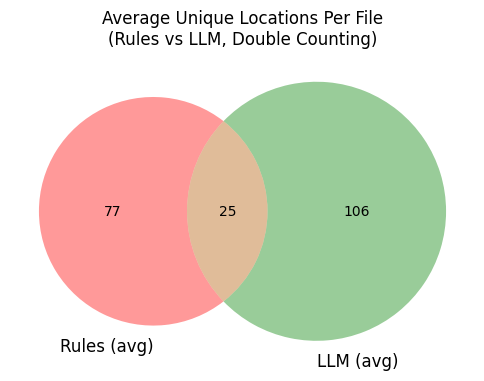

In [53]:
stats = pd.read_csv("/content/drive/MyDrive/Merged_Locations/llm_vs_rules_summary.csv")
## Venn diagram of merged locations
avg_unique_to_rules = stats['unique_to_rules'].mean()
avg_unique_to_llm = stats['unique_to_llm'].mean()
avg_both = stats['both'].mean()

print("\nAverage (per file):")
print(f"  Rules only: {avg_unique_to_rules:.1f}")
print(f"  LLM only:   {avg_unique_to_llm:.1f}")
print(f"  Both:       {avg_both:.1f}")

plt.figure(figsize=(6,5))
venn2(subsets=(round(avg_unique_to_rules),
        round(avg_unique_to_llm),
        round(avg_both)), set_labels=('Rules (avg)', 'LLM (avg)'))
plt.title("Average Unique Locations Per File\n(Rules vs LLM, Double Counting)")
plt.show()


## Geocoding and Mapping

This section parses coordinates (decimal, DMS, UTM), performs geocoding using GeoPy, and visualizes results on an interactive Folium map. It adds latitude, longitude, accuracy, and type columns while removing rule-only rows. Maps display each location’s mentions and page numbers for verification.

In [55]:
def is_citation(mention, loc):
    # Looks for patterns like "Ledru et al.", "(Taylor, 1990)", etc.
    return bool(re.search(rf"\b{re.escape(loc)}\b.*et al\.?", mention, re.IGNORECASE)) or \
           bool(re.search(rf"\({re.escape(loc)}, \d{{4}}\)", mention))

In [56]:
nlp = spacy.load("en_core_web_sm")
def is_person_entity(loc):
    doc = nlp(loc)
    return any(ent.label_ == "PERSON" for ent in doc.ents)

In [57]:
def is_author_like(loc, mention):
    loc_clean = loc.strip()
    if is_citation(mention, loc_clean):
        return True
    if is_person_entity(loc_clean):
        return True
    return False

In [58]:
def filter_out_authors(df):
    # Expects 'location' and 'mentions' columns
    mask = df.apply(lambda row: not is_author_like(row['location'], row['mentions']), axis=1)
    return df[mask].reset_index(drop=True)

In [59]:
GENERIC_LOCATION_WORDS = [
    "study area", "area of study", "area of investigation", "study region", "study site",
    "study location", "area", "region", "zone", "locality", "localities",
    "the area", "the region", "investigation area", "site", "sites"
]

def remove_generic_location_words(location):
    """
    Removes generic location words/phrases (case-insensitive) from start or end of a location string.
    """
    if not isinstance(location, str):
        return location
    s = location.strip()

    pattern = r"^(%s)\b[\s,:\-]*|[\s,:\-]*(%s)$" % (
        "|".join(map(re.escape, GENERIC_LOCATION_WORDS)),
        "|".join(map(re.escape, GENERIC_LOCATION_WORDS))
    )
    s = re.sub(pattern, "", s, flags=re.IGNORECASE)

    s = re.sub(r"\s+", " ", s)
    s = s.strip(",.:-; ")
    return s

In [60]:
def is_gps(s):
    # Simple patterns for decimal/sexagesimal degrees or UTM
    s = str(s).strip()
    # Simple decimal degree/UTM/Easting-Northing patterns:
    if re.match(r"^\d{5,}[-; ]\s*\d{5,}$", s):  # e.g., 0184836-1587581 or 1534836; 0216256
        return True
    # Matches "N 14 36 37 8 E 00 00 12 1" etc.
    if re.search(r"[NSEW]\s*\d+", s) and re.search(r"[EW]\s*\d+", s):
        return True
    # Matches "GPS" in string (sometimes extracted as "GPS 14 35 05 7 W 00 00 05 4")
    if s.upper().startswith("GPS"):
        return True
    return False


def is_approximate(loc):
    if pd.isna(loc): return False
    loc = str(loc).strip()
    # Match "NE of Burkina Faso", "southern part of Ghana", etc.
    direction = r"(?:N|S|E|W|NE|NW|SE|SW|North|South|East|West|Northern|Southern|Eastern|Western)"
    if re.match(rf"^{direction}(\s+part)?\s+of\s+.+", loc, flags=re.IGNORECASE):
        return True
    if re.match(rf"^.+\b({direction})\b", loc, flags=re.IGNORECASE):
        return True
    return False

def is_geounit(s):
    geo_unit_keywords = [
        "belt", "craton", "basin", "shear zone", "fault", "batholith", "terrane", "inlier",
        "province", "region", "mine", "group", "supergroup", "pluton", "complex", "gneiss", "channel", "graben","domain"
    ]
    s = s.lower().strip()
    # Don't count plain country names as geounit
    return any(kw in s for kw in geo_unit_keywords)

def classify_location_type(loc):
    loc = str(loc)
    if is_gps(loc):
        return "GPS"
    elif is_approximate(loc):
        return "APPROXIMATE"
    elif is_geounit(loc):
        return "GEOLOGICAL_UNIT"
    elif len(loc) < 3:
        return "UNGEOCODED"
    else:
        return "PLACE"

In [61]:
def extract_base_place(location):
    """
    Attempt to extract the most likely base location from a regional phrase.
    - Strips out directional modifiers and keeps the likely toponyms.
    - Works best for phrases like "eastern part of X", "near Y", etc.
    """
    # 1. Try 'of ...' or 'in ...'
    match = re.search(r'of ([A-Za-z \-\’\'éèêàôîïç]+)$', location)
    if match:
        return match.group(1).strip()
    match = re.search(r'in ([A-Za-z \-\’\'éèêàôîïç]+)$', location)
    if match:
        return match.group(1).strip()
    # 2. Remove phrases like 'part of', 'region of', 'border with'
    cleaned = re.sub(r'^(north|south|east|west|northern|southern|eastern|western|central|upper|lower|border|area|part|region|near|around|about|along)\s+of\s+', '', location, flags=re.I)
    cleaned = re.sub(r'^(north|south|east|west|northern|southern|eastern|western|central|upper|lower|border|area|part|region|near|around|about|along)\s+', '', cleaned, flags=re.I)
    cleaned = cleaned.strip(",.;:()[] ")

    # 3. If there are coordinates, skip
    if re.search(r'\d{4,}', cleaned):
        return location.strip()

    # 4. Return the last capitalized chunk (if any)
    matches = re.findall(r'\b([A-Z][a-zA-Z\'\-éèêàôîïç]+(?: [A-Z][a-zA-Z\'\-éèêàôîïç]+)*)\b', cleaned)
    if matches:
        return matches[-1]

    return cleaned.strip()

In [62]:
geolocator = Nominatim(user_agent="geo_coding_example")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Geocode function with handling for failures
def geopy_geocode(loc):
    if not loc or loc.lower() in {"gps", "na", "no-geocode-result"}:
        return pd.Series(["no-geocode-result"] * 4)
    # full location first
    try:
        result = geocode(loc, language='en', addressdetails=True, timeout=10)
        if result:
            return pd.Series([result.latitude, result.longitude, result.address, "APPROXIMATE"])
    except Exception as e:
        print(f"Error geocoding '{loc}': {e}")

        time.sleep(1)

    # base place extraction for locality descriptions e.g., NorthEast of Guinea will geocode Guinea
    base = extract_base_place(loc)
    if base and base.lower() != loc.lower():
        try:
            result = geocode(base, language='en', addressdetails=True, timeout=10)
            if result:
                return pd.Series([result.latitude, result.longitude, result.address, "APPROXIMATE"])
        except Exception as e:
            print(f"Error geocoding fallback '{base}': {e}")
            time.sleep(1)

    return pd.Series(["no-geocode-result"] * 4)

In [64]:
def is_valid_location(loc):
    """Reject citations, years, and empty strings."""
    if not isinstance(loc, str) or not loc.strip():
        return False
    if "et al" in loc.lower():
        return False
    if re.search(r"\b(19|20)\d{2}\b", loc):  # any year like 1998, 2006
        return False
    return True

def filter_out_authors(df):
    """Filter rows that look like author names instead of real places."""
    denylist = {"potrel","björklund","eriksson","milési","villeneuve",
                "attoh","ekwueme","shanmugan","sultan"}
    mask = df['location'].apply(
        lambda x: is_valid_location(x) and x.lower() not in denylist
    )
    return df[mask].reset_index(drop=True)

def clean_location_csv_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for fname in os.listdir(input_folder):
        if not fname.lower().endswith(".csv"):
            continue
        print(f"Processing: {fname}")
        df = pd.read_csv(os.path.join(input_folder, fname))
        original_len = len(df)

        # Clean location column
        if 'location' in df.columns:
            df['location'] = df['location'].map(remove_generic_location_words)
        else:
            print(f"Skipping {fname}: no 'location' column")
            continue

        # Drop empty after cleaning
        df_cleaned = df[df['location'].astype(str).str.strip().astype(bool)].reset_index(drop=True)

        # Remove authors (denylist + regex)
        if {'location', 'mentions'}.issubset(df_cleaned.columns):
            df_cleaned = filter_out_authors(df_cleaned)

        # Classify location type
        if 'location' in df_cleaned.columns:
            df_cleaned['location_type'] = df_cleaned['location'].map(classify_location_type)
        else:
            df_cleaned['location_type'] = 'UNGEOCODED'

        print(f"Kept {len(df_cleaned)}/{original_len} locations after filtering.")
        # Save
        outpath = os.path.join(output_folder, fname.replace(".csv", "_final.csv"))
        df_cleaned.to_csv(outpath, index=False)
        print(f"Saved cleaned: {outpath}")

clean_location_csv_folder("/content/drive/MyDrive/Merged_Locations", "/content/drive/MyDrive/Extracted_Location_Final")


Processing: 2011_peters_eastmarkoye_2011_merged.csv
Kept 155/155 locations after filtering.
Saved cleaned: /content/drive/MyDrive/Extracted_Location_Final/2011_peters_eastmarkoye_2011_merged_final.csv
Processing: 2010_matsheka_irvinfinalthesis_merged.csv
Kept 107/107 locations after filtering.
Saved cleaned: /content/drive/MyDrive/Extracted_Location_Final/2010_matsheka_irvinfinalthesis_merged_final.csv
Processing: 2015_lebrun_siguiri_merged.csv
Kept 512/512 locations after filtering.
Saved cleaned: /content/drive/MyDrive/Extracted_Location_Final/2015_lebrun_siguiri_merged_final.csv
Processing: 2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss_merged.csv
Kept 43/45 locations after filtering.
Saved cleaned: /content/drive/MyDrive/Extracted_Location_Final/2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss_merged_final.csv
Processing: 2009_bontlenkuna_0605886p_honoursreport_merged.csv
Kept 80/81 locations after fi

In [66]:
# Patterns of Coordinates extracted
_DEC_PAIR = re.compile(r'^\s*([+-]?\d+(?:\.\d+)?)\s*[,;\s]\s*([+-]?\d+(?:\.\d+)?)\s*$')
_UTM_WITH_ZONE = re.compile(r'^\s*(\d{1,2}|60)\s*([NSns])\s*[,;\s]\s*(\d{5,7})\s*[,;\s]\s*(\d{6,8})\s*$')
# NEW: UTM zone + band (e.g., "30P 694686; 1443104")
_UTM_WITH_BAND = re.compile(r'^\s*(\d{1,2}|60)\s*([C-HJ-NP-Xc-hj-np-x])\s*[,;\s]\s*(\d{5,7})\s*[,;\s]\s*(\d{6,8})\s*$')
# Keep your "bare" — also matches dash "0184836-1587581"
_UTM_BARE = re.compile(r'^\s*(?:GPS\s*=\s*)?(\d{6,8})\s*[-;,]\s*(\d{6,8})\s*$')
# NEW: "0805000 E, 1594000 N" or "570950E and 1245150N"
_UTM_E_AND_N = re.compile(r'(?ix)\b(?P<e>\d{5,7})\s*(?:m?E|E)\b.*?(?P<n>\d{6,8})\s*(?:m?N|N)\b')
# NEW: "WGS84, UTM 29N, East.: 415178, North.: 1290080"
_UTM_LABELLED = re.compile(
    r'(?ix)\b(?:WGS84\s*,\s*)?UTM\s*(?P<zone>\d{1,2})(?P<tail>[A-Z])?'
    r'\s*,?\s*East\.?:\s*(?P<e>\d{5,7})\s*,\s*North\.?:\s*(?P<n>\d{6,8})'
)

def _dms_to_dec(hem, d, m, s_whole, s_tenths):
    d = int(d); m = int(m); s = float(f"{int(s_whole)}.{int(s_tenths)}")
    if s >= 60: m += int(s // 60); s %= 60
    if m >= 60: d += int(m // 60); m %= 60
    dec = d + m/60.0 + s/3600.0
    return -dec if hem and hem.upper() in ("S","W") else dec

# working split DMS: "N 14 36 37 8 E 00 00 12 1"
def parse_split_dms(txt: str):
    p = str(txt).strip().split()
    # Allow the lat hemisphere to be missing (assume N) and accept "GPS" token at start
    tokens = [t for t in p if t.upper() != "GPS"]
    if len(tokens) == 10 and tokens[0] in ("N","S") and tokens[5] in ("E","W"):
        Hlat, d1,m1,s1,st1, Hlon, d2,m2,s2,st2 = tokens
    elif len(tokens) == 9 and tokens[5] in ("E","W"):
        # e.g., "14 36 37 8 E 00 00 12 1" → assume N for latitude
        Hlat, d1,m1,s1,st1 = "N", tokens[0],tokens[1],tokens[2],tokens[3]
        Hlon, d2,m2,s2,st2 = tokens[4],tokens[5],tokens[6],tokens[7],tokens[8]
    else:
        return (np.nan, np.nan)
    try:
        lat = _dms_to_dec(Hlat, d1, m1, s1, st1)
        lon = _dms_to_dec(Hlon, d2, m2, s2, st2)
        return (lat, lon) if (-90 <= lat <= 90 and -180 <= lon <= 180) else (np.nan, np.nan)
    except:
        return (np.nan, np.nan)

def _band_to_hem(band: str) -> str:
    b = band.upper()
    # UTM latitude bands
    return "S" if "C" <= b <= "M" else "N"

def geocode_location_csv_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for fname in os.listdir(input_folder):
        if not fname.lower().endswith(".csv"):
            continue
        print(f"Geocoding: {fname}")
        df = pd.read_csv(os.path.join(input_folder, fname))
        if 'location' not in df.columns:
            print(f"SKIP (no location column): {fname}")
            continue

        # Keep LLM & LLM,Rules (skip rules-only)
        df = df[df['source'].astype(str).str.lower().str.contains('llm')].copy()

        #PARSE ON RAW TEXT
        raw_loc = df['location'].astype(str).str.strip()

        # Trying to deal with GPS coordinates extracted from papers
        dec = raw_loc.str.extract(_DEC_PAIR)
        dec_lat = pd.to_numeric(dec[0], errors='coerce')
        dec_lon = pd.to_numeric(dec[1], errors='coerce')
        good_dec = dec_lat.between(-90,90) & dec_lon.between(-180,180)

        # UTM with zone+hemisphere (e.g., "30 N, 694686, 1443104")
        utm = raw_loc.str.extract(_UTM_WITH_ZONE)
        utm_zone = pd.to_numeric(utm[0], errors='coerce')
        utm_hem  = utm[1].str.upper()
        utm_e    = pd.to_numeric(utm[2], errors='coerce')
        utm_n    = pd.to_numeric(utm[3], errors='coerce')
        mask_utm = utm_zone.notna() & utm_hem.notna() & utm_e.notna() & utm_n.notna()

        utm_lat = pd.Series(np.nan, index=df.index, dtype=float)
        utm_lon = pd.Series(np.nan, index=df.index, dtype=float)
        if mask_utm.any():
            uniq = pd.DataFrame({'z': utm_zone, 'h': utm_hem}).dropna().drop_duplicates()
            transformers = {(int(z), h): Transformer.from_crs(
                f"EPSG:{'326' if h=='N' else '327'}{int(z):02d}", "EPSG:4326", always_xy=True)
                for z, h in uniq.itertuples(index=False)}
            for (z,h), T in transformers.items():
                rows = (utm_zone==z) & (utm_hem==h) & mask_utm
                if rows.any():
                    lon_vals, lat_vals = T.transform(utm_e[rows].astype(float).values,
                                                     utm_n[rows].astype(float).values)
                    utm_lon.loc[rows] = lon_vals
                    utm_lat.loc[rows] = lat_vals
        good_utm = utm_lat.notna() & utm_lon.notna()

        # UTM with zone+band (e.g., "30P 694686; 1443104")
        utmb = raw_loc.str.extract(_UTM_WITH_BAND)
        if isinstance(utmb, pd.DataFrame) and not utmb.empty:
            utmb_zone = pd.to_numeric(utmb[0], errors='coerce')
            utmb_band = utmb[1].str.upper()
            utmb_e    = pd.to_numeric(utmb[2], errors='coerce')
            utmb_n    = pd.to_numeric(utmb[3], errors='coerce')
            mask_utmb = utmb_zone.notna() & utmb_band.notna() & utmb_e.notna() & utmb_n.notna()
            if mask_utmb.any():
                # Infer hemisphere from band letter
                utmb_hem = utmb_band.map(_band_to_hem)
                uniqb = pd.DataFrame({'z': utmb_zone, 'h': utmb_hem}).dropna().drop_duplicates()
                transformers_b = {(int(z), h): Transformer.from_crs(
                    f"EPSG:{'326' if h=='N' else '327'}{int(z):02d}", "EPSG:4326", always_xy=True)
                    for z, h in uniqb.itertuples(index=False)}
                utmb_lat = pd.Series(np.nan, index=df.index, dtype=float)
                utmb_lon = pd.Series(np.nan, index=df.index, dtype=float)
                for (z,h), T in transformers_b.items():
                    rows = (utmb_zone==z) & (utmb_hem==h) & mask_utmb
                    if rows.any():
                        lon_vals, lat_vals = T.transform(utmb_e[rows].astype(float).values,
                                                         utmb_n[rows].astype(float).values)
                        utmb_lon.loc[rows] = lon_vals
                        utmb_lat.loc[rows] = lat_vals
                # Merge these into UTM results (prefer explicit zone+band over heuristics)
                overwrite = utmb_lat.notna() & utmb_lon.notna()
                utm_lat.loc[overwrite] = utmb_lat[overwrite]
                utm_lon.loc[overwrite] = utmb_lon[overwrite]
                good_utm = utm_lat.notna() & utm_lon.notna()

        # split-DMS ("N 14 36 37 8 E 00 00 12 1" and also allow missing N)
        dms_latlon = raw_loc.apply(lambda s: pd.Series(parse_split_dms(s), index=['lat_dms','lon_dms']))
        dms_lat, dms_lon = dms_latlon['lat_dms'], dms_latlon['lon_dms']
        good_dms = dms_lat.notna() & dms_lon.notna()

        # UTM labelled "E/N" (e.g., "0805000 E, 1594000 N" / "570950E and 1245150N")
        en = raw_loc.str.extract(_UTM_E_AND_N)
        en_e = pd.to_numeric(en['e'], errors='coerce')
        en_n = pd.to_numeric(en['n'], errors='coerce')
        good_en = en_e.notna() & en_n.notna()

        # bare UTM like "1534765; 0216396" or "0184836-1587581"
        bare = raw_loc.str.extract(_UTM_BARE)
        a = pd.to_numeric(bare[0], errors='coerce'); b = pd.to_numeric(bare[1], errors='coerce')
        e_guess, n_guess = a.copy(), b.copy()
        swap = a > b  # sometimes northing first
        e_guess[swap], n_guess[swap] = b[swap], a[swap]
        good_bare_pair = e_guess.between(100000,900000) & n_guess.between(0,10000000)

        # Heuristic convert EN (no zone): try zones 30/31/32; keep those within Burkina Faso bbox
        def _heuristic_utm_to_ll(e_ser, n_ser, cond):
            out_lat = pd.Series(np.nan, index=df.index, dtype=float)
            out_lon = pd.Series(np.nan, index=df.index, dtype=float)
            if not cond.any(): return out_lat, out_lon
            for z in (30,31,32):
                T = Transformer.from_crs(f"EPSG:326{z:02d}", "EPSG:4326", always_xy=True)
                rows = cond & out_lat.isna()
                if rows.any():
                    lon_vals, lat_vals = T.transform(e_ser[rows].astype(float).values,
                                                     n_ser[rows].astype(float).values)
                    inside = (lat_vals >= 9) & (lat_vals <= 16) & (lon_vals >= -6) & (lon_vals <= 3)
                    if inside.any():
                        idx = e_ser[rows].index[inside]
                        out_lon.loc[idx] = np.array(lon_vals)[inside]
                        out_lat.loc[idx] = np.array(lat_vals)[inside]
            return out_lat, out_lon

        en_lat, en_lon = _heuristic_utm_to_ll(en_e, en_n, good_en)
        bare_lat, bare_lon = _heuristic_utm_to_ll(e_guess, n_guess, good_bare_pair)

        good_en_ll = en_lat.notna() & en_lon.notna()
        good_bare = bare_lat.notna() & bare_lon.notna()


        df['location'] = df['location'].map(remove_generic_location_words)
        geo_df = df['location'].apply(lambda loc: pd.Series(geopy_geocode(loc)))
        geo_df.columns = ['geocode_lat', 'geocode_lon', 'geocode_str', 'geocode_type']
        df = pd.concat([df, geo_df], axis=1)

        # Ensure we can overwrite "no-geocode-result"
        df['geocode_lat'] = pd.to_numeric(df['geocode_lat'], errors='coerce')
        df['geocode_lon'] = pd.to_numeric(df['geocode_lon'], errors='coerce')
        if 'location_type' not in df.columns:
            df['location_type'] = np.nan

        # OVERRIDE (priority: bare/en < DMS < UTM < decimal), and stamp as GPS exact
        # 1) bare UTM heuristic
        df.loc[good_bare, 'geocode_lat']  = bare_lat[good_bare].astype(float)
        df.loc[good_bare, 'geocode_lon']  = bare_lon[good_bare].astype(float)
        df.loc[good_bare, 'geocode_type'] = 'utm_heuristic'
        df.loc[good_bare, 'geocode_str']  = "GPS: " + bare_lat[good_bare].round(6).astype(str) + ", " + bare_lon[good_bare].round(6).astype(str)
        df.loc[good_bare, 'accuracy']     = 'EXTRACTED'
        df.loc[good_bare, 'location_type'] = 'GPS'

        # 1b) E/N labelled heuristic
        df.loc[good_en_ll, 'geocode_lat']  = en_lat[good_en_ll].astype(float)
        df.loc[good_en_ll, 'geocode_lon']  = en_lon[good_en_ll].astype(float)
        df.loc[good_en_ll, 'geocode_type'] = 'utm_heuristic'
        df.loc[good_en_ll, 'geocode_str']  = "GPS: " + en_lat[good_en_ll].round(6).astype(str) + ", " + en_lon[good_en_ll].round(6).astype(str)
        df.loc[good_en_ll, 'accuracy']     = 'EXTRACTED'
        df.loc[good_en_ll, 'location_type'] = 'GPS'

        # 2) DMS split
        df.loc[good_dms, 'geocode_lat']  = dms_lat[good_dms].astype(float)
        df.loc[good_dms, 'geocode_lon']  = dms_lon[good_dms].astype(float)
        df.loc[good_dms, 'geocode_type'] = 'dms'
        df.loc[good_dms, 'geocode_str']  = "GPS: " + dms_lat[good_dms].round(6).astype(str) + ", " + dms_lon[good_dms].round(6).astype(str)
        df.loc[good_dms, 'accuracy']     = 'EXTRACTED'
        df.loc[good_dms, 'location_type'] = 'GPS'

        # 3) UTM (zone+hem or zone+band, incl. "UTM 29N East./North.")
        df.loc[good_utm, 'geocode_lat']  = utm_lat[good_utm].astype(float)
        df.loc[good_utm, 'geocode_lon']  = utm_lon[good_utm].astype(float)
        df.loc[good_utm, 'geocode_type'] = 'utm'
        df.loc[good_utm, 'geocode_str']  = "GPS: " + utm_lat[good_utm].round(6).astype(str) + ", " + utm_lon[good_utm].round(6).astype(str)
        df.loc[good_utm, 'accuracy']     = 'EXTRACTED'
        df.loc[good_utm, 'location_type'] = 'GPS'

        # 4) decimal
        df.loc[good_dec, 'geocode_lat']  = dec_lat[good_dec].astype(float)
        df.loc[good_dec, 'geocode_lon']  = dec_lon[good_dec].astype(float)
        df.loc[good_dec, 'geocode_type'] = 'decimal'
        df.loc[good_dec, 'geocode_str']  = "GPS: " + dec_lat[good_dec].round(6).astype(str) + ", " + dec_lon[good_dec].round(6).astype(str)
        df.loc[good_dec, 'accuracy']     = 'EXTRACTED'
        df.loc[good_dec, 'location_type'] = 'GPS'

        out_csv = os.path.join(output_folder, fname.replace(".csv", "_geocoded.csv"))
        df.to_csv(out_csv, index=False)
        print(f"Saved geocoded file: {out_csv}")

# Run
geocode_location_csv_folder("/content/drive/MyDrive/Extracted_Location_Final", "/content/drive/MyDrive/Locations_geocoded")

Geocoding: 2011_peters_eastmarkoye_2011_merged_final.csv
Saved geocoded file: /content/drive/MyDrive/Locations_geocoded/2011_peters_eastmarkoye_2011_merged_final_geocoded.csv
Geocoding: 2010_matsheka_irvinfinalthesis_merged_final.csv
Saved geocoded file: /content/drive/MyDrive/Locations_geocoded/2010_matsheka_irvinfinalthesis_merged_final_geocoded.csv
Geocoding: 2015_lebrun_siguiri_merged_final.csv
Saved geocoded file: /content/drive/MyDrive/Locations_geocoded/2015_lebrun_siguiri_merged_final_geocoded.csv
Geocoding: 2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss_merged_final.csv
Saved geocoded file: /content/drive/MyDrive/Locations_geocoded/2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss_merged_final_geocoded.csv
Geocoding: 2009_bontlenkuna_0605886p_honoursreport_merged_final.csv
Saved geocoded file: /content/drive/MyDrive/Locations_geocoded/2009_bontlenkuna_0605886p_honoursreport_merged_final_geocoded.c

In [67]:
input_dir = Path("/content/drive/MyDrive/Locations_geocoded")
output_dir = Path("/content/drive/MyDrive/Locations_Maps")
output_dir.mkdir(parents=True, exist_ok=True)

# Function to build a map for one file
def build_map(csv_path, output_dir):
    df = pd.read_csv(csv_path)

    # keep only valid coords
    df = df[df['geocode_lat'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    df['geocode_lat'] = df['geocode_lat'].astype(float)
    df['geocode_lon'] = df['geocode_lon'].astype(float)

    if df.empty:
        print(f" Skipping {csv_path.name} (no valid coordinates)")
        return

    # Accuracy: exact or approximate
    def accuracy(row):
        gstr = str(row.get("geocode_str", "")).lower()
        if "approx" in gstr or "near" in gstr:
            return "approximate"
        return "exact"

    df["accuracy"] = df.apply(accuracy, axis=1)

    # Assign colors automatically per unique location_type
    unique_types = df["location_type"].dropna().unique()
    color_cycle = itertools.cycle(
        ["blue","green","red","purple","orange","cyan","pink","brown","gray","olive"]
    )
    COLOR_MAP = {lt: next(color_cycle) for lt in unique_types}

    def color_for(row):
        return COLOR_MAP.get(row.get("location_type", ""), "black")

    # Center map
    center_lat = df["geocode_lat"].mean()
    center_lon = df["geocode_lon"].mean()
    m = folium.Map(location=[center_lat, center_lon],zoom_start=6,tiles='cartodbpositron',attr='© OpenStreetMap contributors, © CARTO')


    for _, row in df.iterrows():
        popup_text = (
            f"<b>Location:</b> {row.get('location_clean', '')}<br>"
            f"<b>Context:</b> {row.get('mentions', row.get('mention', ''))}<br>"
            f"<b>Geocode:</b> {row.get('geocode_str', '')}<br>"
            f"<b>Pages:</b> {row.get('pages', '')}<br>"
            f"<b>Type:</b> {row.get('location_type', '')}<br>"
            f"<b>Accuracy:</b> {row['accuracy']}"
        )

        folium.CircleMarker(
            location=[row["geocode_lat"], row["geocode_lon"]],
            radius=7,
            color=color_for(row),
            fill=True,
            fill_color=color_for(row),
            fill_opacity=0.7 if row["accuracy"] == "exact" else 0.3,
            tooltip=row.get("location_clean", ""),
            popup=folium.Popup(popup_text, max_width=350),
        ).add_to(m)


    legend_html = """
    <div style="position: fixed; bottom: 20px; left: 20px; z-index: 9999;
                background: white; padding: 8px 10px; border: 1px solid #ccc; border-radius: 4px;">
      <div style="font-weight: 600; margin-bottom: 6px;">Legend (location_type)</div>
    """
    for lt, col in COLOR_MAP.items():
        legend_html += f"""
          <div><span style="display:inline-block;width:12px;height:12px;background:{col};
                             margin-right:6px;border-radius:50%;"></span>{lt}</div>
        """
    legend_html += """
      <div style="margin-top:6px;"><i>Transparency: solid = exact, faint = approximate</i></div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))


    out_path = output_dir / (csv_path.stem + "_map.html")
    m.save(out_path)
    print(f"Saved map: {out_path}")


for csv_file in input_dir.glob("*.csv"):
    build_map(csv_file, output_dir)

Saved map: /content/drive/MyDrive/Locations_Maps/2011_peters_eastmarkoye_2011_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2010_matsheka_irvinfinalthesis_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2015_lebrun_siguiri_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2012_simoko_petrology,geochemistryandstructureofthepissilabatholithandthesaabazonegneiss_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2009_bontlenkuna_0605886p_honoursreport_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2014_msc_yossi_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2013_peters_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2011_woolfe_thestratigraphyandmetamorphicfaciesofthekemb_merged_final_geocoded_map.html
Saved map: /content/drive/MyDrive/Locations_Maps/2015_masurel_phd_m